In [22]:
from data_utils import get_prepared_data
import pandas as pd

# df = get_prepared_data()

# df.to_csv('prepared_data.csv', index=False) 
df = pd.read_csv('prepared_data.csv')  

In [23]:
df["gender"] = (df["gender"] == "F")
df = df.drop("participationStartDate", axis=1)
df

,bpm,pcode,bpm-1min,bpm-5min,bpm-10min,temperature,temperature-1min,temperature-5min,temperature-10min,brightness,...,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,64.0,P67,64.0,72.0,73.0,32.020000,32.020000,32.290001,32.799999,0.0,...,21,False,12,9,5,12,9,14,5,7
1,76.0,P62,74.0,82.0,77.0,32.560001,32.330002,32.389999,32.330002,0.0,...,20,False,15,15,9,11,7,24,4,19
2,75.0,P69,42.0,77.0,71.0,29.549999,29.420000,28.809999,29.020000,6.0,...,18,False,3,6,10,9,7,22,4,16
3,78.0,P70,78.0,78.0,83.0,34.099998,34.020000,33.939999,33.980000,21.0,...,38,False,12,10,8,8,7,14,1,10
4,70.0,P01,74.0,72.0,78.0,30.070000,29.879999,29.200001,31.709999,122.0,...,27,False,11,11,3,4,13,13,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,82.0,P12,77.0,75.0,91.0,33.230000,33.320000,33.950001,33.950001,145.0,...,20,False,9,12,7,7,12,14,6,4
1300,74.0,P76,73.0,78.0,89.0,34.959999,35.020000,35.230000,35.230000,0.0,...,18,False,8,8,12,6,8,21,14,21
1301,75.0,P66,90.0,105.0,93.0,33.200001,33.119999,32.799999,32.630001,0.0,...,18,False,8,10,8,8,10,19,10,13
1302,69.0,P79,80.0,70.0,71.0,30.830000,30.530001,28.990000,28.760000,113.0,...,23,False,9,10,7,12,11,13,2,6


**Split into train and test sets**

In [24]:
from sklearn.model_selection import train_test_split
import random

pcodes = list(set(df["pcode"]))
test_pcodes = set([random.choice(pcodes) for _ in range(int(0.1*len(pcodes)))])

test_pcodes_df = df[df["pcode"].isin(test_pcodes)]
df =  df[~df["pcode"].isin(test_pcodes)]

df = df.drop("pcode", axis=1)
test_pcodes_df = test_pcodes_df.drop("pcode", axis=1)

y_columns = ['valence', 'arousal', 'attention', 'stress']
X = df.drop(y_columns, axis=1)
y = df[y_columns]

X_test_pcodes = test_pcodes_df.drop(y_columns, axis=1)
y_test_pcodes = test_pcodes_df[y_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

X_test = pd.concat([X_test, X_test_pcodes], ignore_index=True)
y_test = pd.concat([y_test, y_test_pcodes], ignore_index=True)

In [25]:
len(X_test), len(X_train)

(262, 1042)

**Logistic Regression**

In [26]:
import numpy as np
from mord import LogisticIT  # LogisticIT is for immediate-threshold ordinal regression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from model_utils import get_metrics, plot_model_comparison

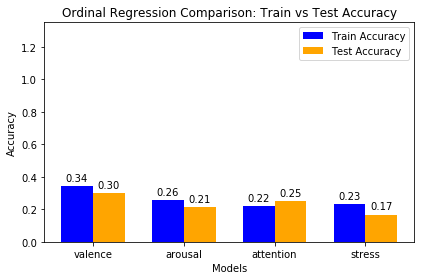

In [27]:
ordinal_train_acc = []
ordinal_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    # Create and train the ordinal regression model
    ordinal_model = LogisticIT()
    ordinal_model.fit(X_train, y_train[target])

    test_preds = ordinal_model.predict(X_test)
    train_preds = ordinal_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    ordinal_train_acc.append(train_accuracy)
    ordinal_test_acc.append(test_accuracy)

plot_model_comparison("Ordinal Regression", y_columns, ordinal_test_acc, ordinal_train_acc)


**Random Forest Classifier**

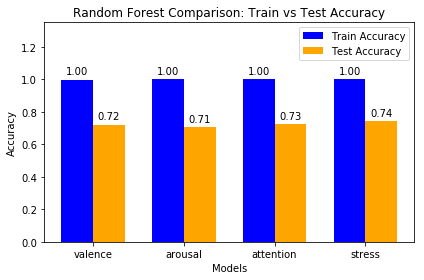

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_train_acc = []
rf_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    # Create and train the ordinal regression model
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train[target])

    test_preds = rf_model.predict(X_test)
    train_preds = rf_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    rf_train_acc.append(train_accuracy)
    rf_test_acc.append(test_accuracy)

plot_model_comparison("Random Forest", y_columns, rf_test_acc, rf_train_acc)


**Neural Net**

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

inputs = layers.Input(shape=X_train.shape[1])

m = layers.Dense(256, activation='relu')(inputs)
m = layers.Dropout(0.2)(m)
m = layers.Dense(128, activation='relu')(m)
m = layers.Dropout(0.2)(m)
m = layers.Dense(64, activation='relu')(m)
m = layers.Dropout(0.2)(m)
m = layers.Dense(16, activation='relu')(m)

valence_output = layers.Dense(7, activation='softmax', name='valence')(m)
arousal_output = layers.Dense(7, activation='softmax', name='arousal')(m)
attention_output = layers.Dense(7, activation='softmax', name='attention')(m)
stress_output = layers.Dense(7, activation='softmax', name='stress')(m)

model = models.Model(inputs=inputs, outputs=[valence_output, arousal_output, attention_output, stress_output])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],

)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          6912        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256)          0           dense_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          32896       dropout_2[0][0]                  
____________________________________________________________________________________________

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Add 3 to convert to 0 to 6 instead of -3 to 3
y_train_valence = y_train['valence'].values + 3
y_train_arousal = y_train['arousal'].values + 3
y_train_attention = y_train['attention'].values + 3
y_train_stress = y_train['stress'].values + 3

y_test_valence = y_test['valence'].values + 3
y_test_arousal = y_test['arousal'].values + 3
y_test_attention = y_test['attention'].values + 3
y_test_stress = y_test['stress'].values + 3


In [36]:
from model_utils import plot_training_history

history = model.fit(
    X_train_scaled,
    {
        'valence': y_train_valence,
        'arousal': y_train_arousal,
        'attention': y_train_attention,
        'stress': y_train_stress
    },
    epochs=200,
    batch_size=64,
    validation_split=0.2
)

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 2s 3ms/sample - loss: 7.7298 - valence_loss: 1.9106 - arousal_loss: 1.9453 - attention_loss: 1.9271 - stress_loss: 1.9105 - valence_acc: 0.1921 - arousal_acc: 0.1501 - attention_acc: 0.2053 - stress_acc: 0.2065 - val_loss: 7.5964 - val_valence_loss: 1.8324 - val_arousal_loss: 1.9280 - val_attention_loss: 1.9538 - val_stress_loss: 1.9081 - val_valence_acc: 0.2727 - val_arousal_acc: 0.1722 - val_attention_acc: 0.1675 - val_stress_acc: 0.2679
Epoch 2/200
833/833 [==============================] - 1s 652us/sample - loss: 7.4614 - valence_loss: 1.7422 - arousal_loss: 1.9059 - attention_loss: 1.9242 - stress_loss: 1.8675 - valence_acc: 0.3445 - arousal_acc: 0.1513 - attention_acc: 0.2089 - stress_acc: 0.2605 - val_loss: 7.3590 - val_valence_loss: 1.7217 - val_arousal_loss: 1.8502 - val_attention_loss: 1.9106 - val_stress_loss: 1.8681 - val_valence_acc: 0.3254 - val_arousal_acc: 0.2010 - val_a

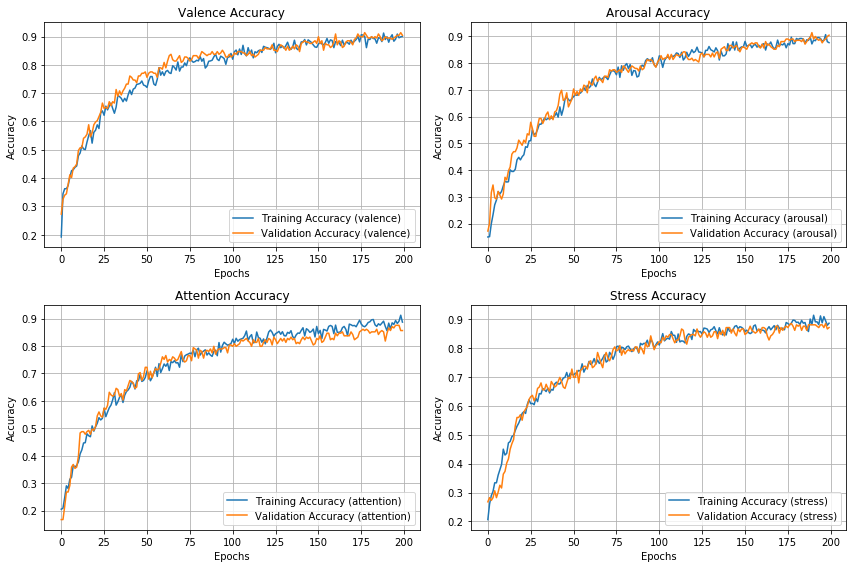

In [37]:
plot_training_history(history=history)

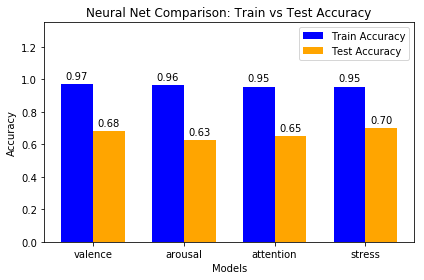

In [39]:
nn_train_acc = []
nn_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    model.predict(X_test_scaled)

    # Subtract 3 to convert back to 0 to 6
    test_preds = np.argmax(model.predict(X_test_scaled)[i], axis=1) - 3
    train_preds = np.argmax(model.predict(X_train_scaled)[i], axis=1) - 3

    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    nn_train_acc.append(train_accuracy)
    nn_test_acc.append(test_accuracy)

plot_model_comparison("Neural Net", y_columns, nn_test_acc, nn_train_acc)
